# I] Import and options


In [39]:
import pandas, numpy, seaborn, scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt

In [40]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(12, 8), 'svg.fonttype' : 'none'})

In [41]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

In [70]:
path = "mefs/mefs_western_blot/mitochondria/"

# II] DL data

In [71]:
# WRONG THEY ARE NOT BLOT 1 2 3 BUT NORM BAF AND FCCP

In [82]:
data = "_blot1_allcond", "_blot2_allcond", "_blot3_allcond"

dfs_normalized = []
for blot in data:
    file_n = "mitochondria" + blot + ".csv"
    df = pandas.read_csv(input_file_directory + path + file_n, sep = ";") #download

    df_norm = df[df['blot'] == 'normal']
    df_baf = df[df['blot'] == 'baf']
    df_dmso = df[df['blot'] == 'dmso']
         
    for df in df_norm, df_baf, df_dmso:
                   
        df = df.T #transpose
        df.columns = df.loc['proteins'] #select head of columns
        df.columns.name = None #remove name of index column
        df = df.drop(df.index[0:2])
    
        #normalized columns
        df = df.assign(flag_actin = df['flag']/ df['actin'],
                       hsp60_actin= df['hsp60']/ df['actin'],
                       atpb_actin= df['atpb']/ df['actin']) 
        df = df.iloc[:,4:] #select normalized columns
        df.reset_index(inplace = True)

        dfs_normalized.append(df)
            
# When we will have the three experiments
dfs_norm = pandas.concat([dfs_normalized[0], dfs_normalized[3], dfs_normalized[6]], axis=0)
dfs_baf = pandas.concat([dfs_normalized[1], dfs_normalized[4], dfs_normalized[7]], axis=0)
dfs_dmso = pandas.concat([dfs_normalized[2], dfs_normalized[5], dfs_normalized[8]], axis=0)
dfs_baf

,index,flag_actin,hsp60_actin,atpb_actin
0,ATG7-/-,0.152537,0.727333,0.103577
1,ATG7(1),1.02554,0.822659,0.114691
2,ATG7(2),1.09501,0.457037,0.106984
0,ATG7-/-,0.142183,0.950086,0.584906
1,ATG7(1),1.15358,0.857821,0.583541
2,ATG7(2),1.46628,0.758521,0.24696
0,ATG7-/-,0.255035,1.73286,2.12774
1,ATG7(1),1.7555,1.40466,1.40737
2,ATG7(2),1.80526,1.72937,1.68623


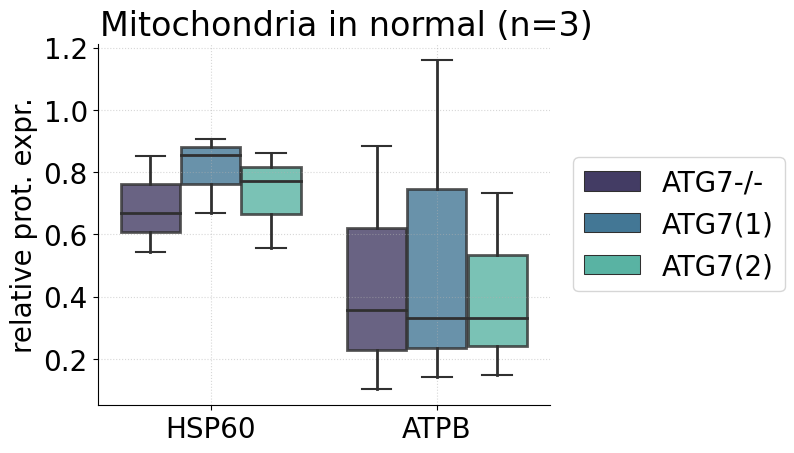

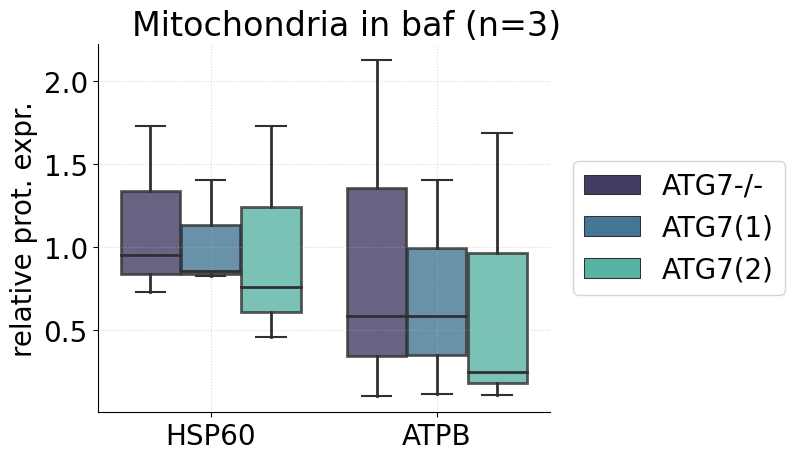

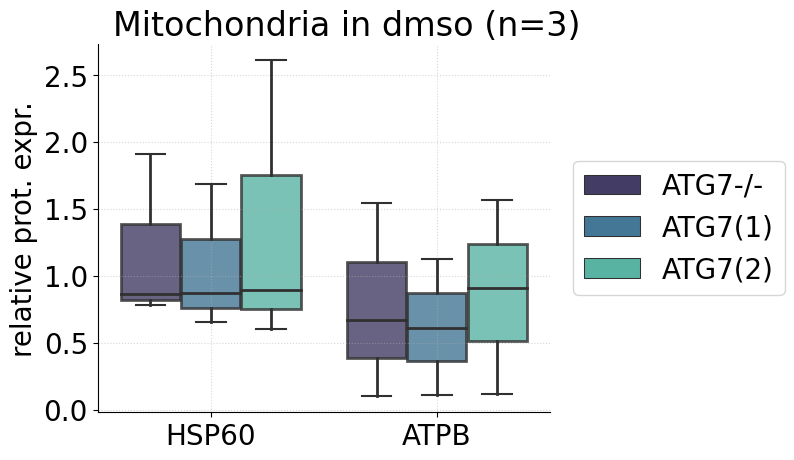

In [86]:
# Distribution: Data preparation + graph
#from wide to long dataframe
dfs = dfs_norm, dfs_baf, dfs_dmso
infos = "normal", "baf", "dmso"

for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]
               
    df = df[['index','hsp60_actin', 'atpb_actin']]
    df = df.rename(columns = {'flag_actin':'Flag','hsp60_actin':'HSP60','atpb_actin':'ATPB'})
    
    df = df.melt(id_vars=["index"], var_name="proteins")

    #graph
    seaborn.catplot(x="proteins", y="value", hue="index", aspect= 1.2, kind="box", palette = 'mako',
                    data = df, boxprops={'lw':2, 'alpha' : 0.8}, medianprops={'lw':2}, whiskerprops={'lw':2}, 
                    showcaps=True, showfliers=False, legend=False)

    plt.tight_layout()
    plt.grid(alpha = 0.5, ls=':')
    plt.ylabel('relative prot. expr.')
    plt.xlabel('')
    plt.title(f'Mitochondria in {info} (n=3)', x=.55)
    plt.legend(loc='center right', fontsize=20, bbox_to_anchor=(1.55, 0.5))

# #save
# path = 'ATG7/MEF/Western_blot/'
# plt.savefig(output_file_directory+path+'ATG7_mitochondria.svg')

In [89]:
df_stats

,index,flag_actin,hsp60_actin,atpb_actin
0,ATG7(1),0.95619,0.866521,0.108634
1,ATG7(1),0.312736,0.656443,0.610647
2,ATG7(1),3.30453,1.68639,1.12476
3,ATG7(2),1.09204,0.604672,0.116684
4,ATG7(2),1.1185,0.890904,0.905255
5,ATG7(2),2.60832,2.60781,1.56333
6,ATG7-/-,0.181753,0.781051,0.104683
7,ATG7-/-,0.105782,0.861919,0.665773
8,ATG7-/-,0.146565,1.90556,1.53977


In [88]:
#Statistics T-test for the means of two independent samples
proteins = 'flag_actin', 'hsp60_actin', 'atpb_actin'
dfs = dfs_norm, dfs_baf, dfs_dmso
infos = "normal", "baf", "dmso"

for i in range(len(dfs)):
    print('\n', info.upper())
    df = dfs[i]
    info = infos[i]

    df_stats = df.sort_values(['index'], ascending = True)
    df_stats.reset_index(drop=True, inplace=True)

    df_iso1 = df_stats.iloc[0:3, :]
    df_iso2 = df_stats.iloc[3:6, :]
    df_ev = df_stats.iloc[6:, :]

    iso1_label = df_stats.loc[0]['index']
    iso2_label = df_stats.loc[3]['index']
    control_label = df_stats.iloc[6]['index']

    for protein in proteins:
        print(protein.upper())
        ## ATG7(1) vs EV
        statistic, pvalue = scipy.stats.ttest_ind(df_iso1[protein], df_ev[protein])
        print("the pvalue between", iso1_label, "and", control_label,"is", "{:.5E}".format(pvalue))
        ## ATG(2) vs EV
        statistic, pvalue = scipy.stats.ttest_ind(df_iso2[protein], df_ev[protein])
        print("the pvalue between", iso2_label, "and", control_label,"is", "{:.5E}".format(pvalue))
          ## ATG7(1) vs ATG7(2)
        statistic, pvalue = scipy.stats.ttest_ind(df_iso1[protein], df_iso2[protein])
        print("the pvalue between", iso1_label, "and", iso2_label,"is", "{:.5E}".format(pvalue))   


 DMSO
FLAG_ACTIN
the pvalue between ATG7(1) and ATG7-/- is 9.57482E-02
the pvalue between ATG7(2) and ATG7-/- is 1.52739E-02
the pvalue between ATG7(1) and ATG7(2) is 9.66253E-01
HSP60_ACTIN
the pvalue between ATG7(1) and ATG7-/- is 3.53285E-01
the pvalue between ATG7(2) and ATG7-/- is 7.60828E-01
the pvalue between ATG7(1) and ATG7(2) is 5.30239E-01
ATPB_ACTIN
the pvalue between ATG7(1) and ATG7-/- is 8.16231E-01
the pvalue between ATG7(2) and ATG7-/- is 8.86882E-01
the pvalue between ATG7(1) and ATG7(2) is 7.15475E-01

 NORMAL
FLAG_ACTIN
the pvalue between ATG7(1) and ATG7-/- is 7.75678E-03
the pvalue between ATG7(2) and ATG7-/- is 3.63283E-03
the pvalue between ATG7(1) and ATG7(2) is 6.60951E-01
HSP60_ACTIN
the pvalue between ATG7(1) and ATG7-/- is 7.77434E-01
the pvalue between ATG7(2) and ATG7-/- is 7.67508E-01
the pvalue between ATG7(1) and ATG7(2) is 9.18231E-01
ATPB_ACTIN
the pvalue between ATG7(1) and ATG7-/- is 7.58016E-01
the pvalue between ATG7(2) and ATG7-/- is 7.60369E-0

In [8]:
df_stats

,index,flag_actin,hsp60_actin,atpb_actin
0,ATG7(1),1.11168,0.855864,0.140605
1,ATG7(1),1.02554,0.822659,0.114691
2,ATG7(1),0.95619,0.866521,0.108634
3,ATG7(2),1.04434,0.862012,0.1476
4,ATG7(2),1.09501,0.457037,0.106984
5,ATG7(2),1.09204,0.604672,0.116684
6,ATG7-/-,0.0905789,0.543363,0.104122
7,ATG7-/-,0.152537,0.727333,0.103577
8,ATG7-/-,0.181753,0.781051,0.104683
